In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from unconstrained_model import posterior, data_generator

In [2]:
def integration(T, f): 
    tot = 0;
    for i in range(len(T)-1):
        tot = tot + (1/2 * (f[i]+f[i+1]) * (T[1]-T[0]))
    return tot

def integrate_opt(T, f): 
    return integrate.trapezoid(f,T)

In [3]:
# integrate method usage
x_ex = np.linspace(0,np.pi,100)
f_ex = np.sin(x_ex)
f_ex2 = np.exp(x_ex)

integrate_opt(x_ex,f_ex),integration(x_ex,f_ex),integrate_opt(x_ex,f_ex2),integration(x_ex,f_ex2)

(1.9998321638939927,
 1.9998321638939935,
 22.142550574231233,
 22.142550574231244)

In [4]:
# EXAMPLE
# input
a = -3
b = 3
g = 100
n = 100
sigma = 1
beta = np.sin(np.linspace(a,b,g)*np.pi/4)
def covariates_kernel(s,t):
    return np.exp(-2*(t-s)**2)
def prior_kernel(s,t):
    return np.exp(-(t-s)**2)

#generation
data = data_generator(b,a,g,beta,n,covariates_kernel, sigma)
T = data.grid()
x,y = data.i_o()

In [5]:
class posterior_opt:
    def __init__(self, T, x, y, prior_kernel,sigma):
        self.T = T
        self.x = x
        self.y = y
        self.prior_kernel = prior_kernel
        self.n = y.shape[0]
        self.g = T.shape[0]
        self.sigma = sigma
        self.K = np.fromfunction(np.vectorize(lambda s, t: self.prior_kernel(self.T[s], self.T[t])), (self.g, self.g), dtype=int)
    
    def Lx(self,t):   
        L = np.zeros(self.n)    
        for i in np.arange(0,self.n):
            L[i] = integrate_opt(self.T,self.K[t, :] * self.x[i,:])
        return L
    
    def R(self,i, j):
        Ri = integrate_opt(self.T, self.K * self.x[i, :][:, np.newaxis])
        return integrate_opt(self.T, Ri * self.x[j, :])
    
    def cov(self):
        return np.array([[self.R(i, j) for j in range(self.n)] for i in range(self.n)])
    
    def posterior_mean_cov(self):
        inv = np.linalg.inv(self.cov() + self.sigma * np.identity(self.n))
        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx(t)),inv),self.y)
            return mean
        def Kstar(s,t):
            cov = self.K[s,t] - np.dot(np.dot(np.transpose(self.Lx(s)),inv),self.Lx(t))
            return cov
        
        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        C = np.fromfunction(np.vectorize(lambda t, s: Kstar(s,t)), (self.g,self.g), dtype=int)
        return m,C
    
    def only_mean(self):
        inv = np.linalg.inv(self.cov() + self.sigma * np.identity(self.n))
        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx(t)),inv),self.y)
            return mean
        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        return m
    
    def fitted_values(self):
        m = self.only_mean()
        return np.fromfunction(np.vectorize(lambda i: integrate_opt(self.T, self.x[i,:]*m)), (self.n,), dtype=int)


In [6]:
import time

s_old = time.time()

p = posterior(T, x, y, prior_kernel, sigma)
fitted = p.fitted_values()

time_old = time.time()-s_old

In [7]:
s_new = time.time()

p_opt = posterior_opt(T, x, y, prior_kernel, sigma)
fitted_opt = p_opt.fitted_values()

time_new = time.time()-s_new

In [8]:
# performance check
time_old,time_new

(62.88062787055969, 0.7409634590148926)

In [9]:
# coherence check
fitted-fitted_opt

array([ 1.74958461e-02, -9.15675131e-02,  1.29179549e-01, -1.42406390e-01,
        9.73165000e-02,  9.17273670e-02,  5.11662877e-02, -1.16267624e-01,
       -2.31327399e-01, -1.80955758e-01,  4.76955622e-02, -6.87538409e-02,
        4.40624275e-02, -1.42355453e-01, -4.09979279e-01, -1.90097308e-01,
       -1.33689321e-01, -2.27837077e-01, -2.33276765e-01, -2.30331714e-01,
       -1.84787850e-01, -2.27971595e-01, -1.43290756e-01,  2.14568842e-01,
        2.27358715e-01, -4.46359858e-01, -1.48767959e-01,  7.11698249e-02,
       -1.26688256e-01, -2.08761653e-01,  1.40377768e-01, -6.32302591e-02,
        1.75234778e-01,  2.60310076e-01, -6.63916910e-02,  3.78505574e-01,
       -8.49060120e-02, -1.48669444e-01,  2.87543974e-02, -1.87679492e-01,
        6.57320912e-02,  1.05013033e-01,  1.10840764e-01, -3.91138976e-01,
        2.77296683e-01,  1.56706882e-01, -6.85263402e-02, -8.48297958e-02,
        2.59656615e-01, -6.27824254e-02, -2.61203868e-01,  1.49084159e-01,
       -8.77090306e-02, -

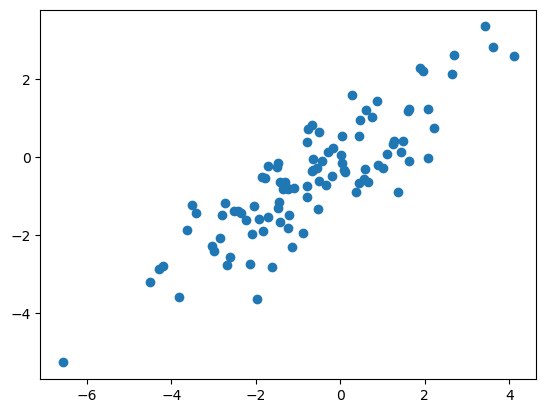

In [11]:
plt.scatter(y,fitted_opt)